In [97]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv
import scipy.optimize as op
import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io 
from scipy.stats import rice
from mpl_toolkits.mplot3d import Axes3D

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr
from scipy.special import stdtr
import csv
import pandas as pd

import sys 
import os
sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code/"))
from Data20200706 import *

from scipy.signal import unit_impulse
from scipy.stats import norm
from scipy import special

from scipy.integrate import tplquad
from scipy import signal


In [84]:
def AIF_DD(A,B,Tdelay):
    t = np.linspace(0,25,100)
    #AifG = unit_impulse(25,'mid')
    AifG = norm.pdf(t,0,.4)
    #pl.plot(AifG)
    DD = np.exp(-(B*t)/Tdelay) * A/(Tdelay + 1)
    Aif_DD = np.convolve(AifG,DD,'full')
    #pl.plot(Aif_DD)
    # and add tdelay zeros to the front where tdelay in seconds = 4*Tdelay zeros
    delay = np.zeros(Tdelay*4)
    Aif_DD = np.concatenate((delay,Aif_DD),axis = 0)
    return AifG,DD,Aif_DD[:100]

#this is the gaussian integral with sigma = sqrt(4Dt)
def integrand(x,D,t):
    sigma = np.sqrt(2*D*t)
    return (1./(sigma*np.sqrt(2*np.pi))) * np.exp(-np.power(x/sigma, 2.)/2) 

def integrand_3D(r,phi,theta,sigma):
    return r**2 * np.sin(theta) * (1./(np.power(sigma*np.sqrt(2*np.pi),3))) * np.exp(-np.power(r/sigma, 2.)/2) 
    
# this integrates a 3D gaussian integral with radius a
def integrate_3Dsphere(a,D,t):
    sigma = np.sqrt(2*D*t)
    integral = tplquad(integrand_3D, 
                       0, np.pi, 0,2*np.pi, 0, a, args=(sigma,))
    return integral[0]

def Residue(D):
    # give diffusion coefficient D
    conc= []
    time = np.linspace(1,60,100)
    a = .5
    for t in time:
        with sns.color_palette('viridis',50): 
            conc_t = integrate_3Dsphere(a,D,t)
            conc = np.append(conc,conc_t)
    return time, conc

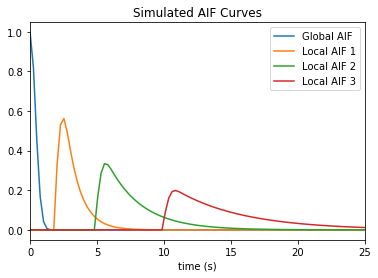

In [117]:
t = np.linspace(0,25,100)
# Tdelay = 2s
g,x,y1 = AIF_DD(1,2,2)
pl.plot(t,g,label = 'Global AIF')
pl.plot(t,y1,label = 'Local AIF 1')

#Tdelay = 5s
g,x,y2 = AIF_DD(1,2,5)
pl.plot(t,y2, label = 'Local AIF 2')

#Tdelay = 15s
g,x,y3 = AIF_DD(1,2,10)
pl.plot(t,y3, label = 'Local AIF 3')

pl.legend()
pl.xlim(0,25)
pl.title('Simulated AIF Curves')
pl.xlabel('time (s)')
pl.show()

In [88]:
t,Rt = Residue(.009)

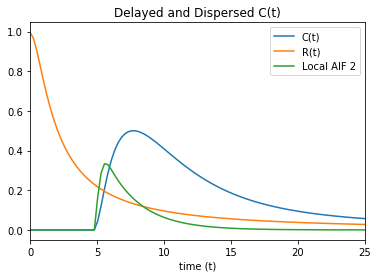

In [116]:
Ct = np.convolve(y2,Rt)
pl.plot(t,Ct[:100]/(2*max(Ct)),label = 'C(t)')
pl.plot(t,Rt[:100],label = 'R(t)')
pl.plot(t,y2, label = 'Local AIF 2')
pl.legend()
pl.xlabel('time (t)')
pl.xlim(0,25)
pl.title('Delayed and Dispersed C(t)')
pl.show()

so above C(t) is what we measure, R(t) is what we want!
If we do delay and dispersion correction, we deconvolve with the Local AIF shown in green. 
If we don't do delay and dispersion correction, we deconvolve with the global AIF. The R(t) will therefore be incorrect. 

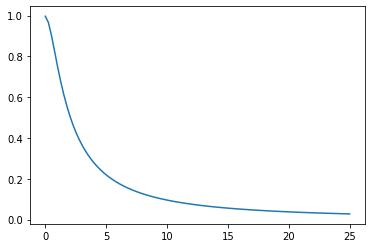

In [110]:
recovered, remainder = signal.deconvolve(Ct,y2[20:])
pl.plot(t,recovered[20:])
pl.show()

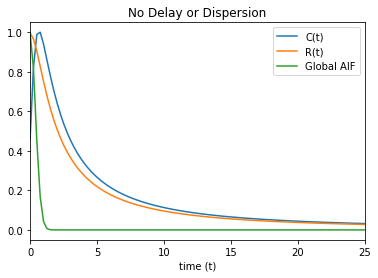

In [111]:
X = np.convolve(g,Rt)
pl.plot(t,X[:100]/max(X),label = 'C(t)')
pl.plot(t,Rt[:100],label = 'R(t)')
pl.plot(t,g, label = 'Global AIF')
pl.legend()
pl.xlabel('time (t)')
pl.xlim(0,25)
pl.title('No Delay or Dispersion')
pl.show()